metrics 4개 파일(동/서/제주/수도) → 하나의 CSV로 합치기
동_변곡점지표_18종_세버전.csv, 서_변곡점지표_18종_세버전.csv, 제주_변곡점지표_18종_세버전.csv, 수도_변곡점지표_18종_세버전.csv

통계검정 결과 4개 파일 → 하나의 CSV로 합치기
동_통계검정결과_18지표.csv, 서_통계검정결과_18지표.csv, 제주_통계검정결과_18지표.csv, 수도_통계검정결과_18지표.csv

각 행에 Region 컬럼 추가해서 “동부/서부/제주/수도” 명시

In [1]:
import pandas as pd
from pathlib import Path

# 지역 이름과 파일 경로 매핑
regions = {
    "East": ["동_변곡점지표_18종_세버전.csv", "동_통계검정결과_18지표.csv"],
    "West": ["서_변곡점지표_18종_세버전.csv", "서_통계검정결과_18지표.csv"],
    "Jeju": ["제주_변곡점지표_18종_세버전.csv", "제주_통계검정결과_18지표.csv"],
    "Seoul": ["수도_변곡점지표_18종_세버전.csv", "수도_통계검정결과_18지표.csv"]
}

metrics_list = []
stats_list = []

for region, (metrics_file, stats_file) in regions.items():
    # metrics 파일 읽고 region 추가
    df_metrics = pd.read_csv(metrics_file)
    df_metrics["Region"] = region
    metrics_list.append(df_metrics)

    # 통계결과 파일 읽고 region 추가
    df_stats = pd.read_csv(stats_file)
    df_stats["Region"] = region
    stats_list.append(df_stats)

# 합친 데이터프레임
metrics_all = pd.concat(metrics_list, ignore_index=True)
stats_all = pd.concat(stats_list, ignore_index=True)

# 저장
metrics_all.to_csv("metrics_all_regions.csv", index=False)
stats_all.to_csv("stats_all_regions.csv", index=False)

In [4]:
import re
import numpy as np
import pandas as pd

# ---------------------------------------
# 0) 입력 파일
# ---------------------------------------
METRICS = "metrics_all_regions.csv"   # 동/서/제주/수도 통합 메트릭
STATS   = "stats_all_regions.csv"     # 동/서/제주/수도 통합 가설검정(p값)

# ---------------------------------------
# 1) 메트릭 파일 로드 & 롱타입 변환
#    (INFLECT_* , DENSITY_*_VISIT / _DIST 파싱)
# ---------------------------------------
m = pd.read_csv(METRICS)

# Region, TRAVEL_ID, MVMN_NM는 그대로 유지
id_cols = ["Region","TRAVEL_ID","MVMN_NM","VISIT_COUNT","TRAVEL_DISTANCE_KM"]
id_cols = [c for c in id_cols if c in m.columns]

value_cols = [c for c in m.columns if c not in id_cols]

records = []
pat_inflect = re.compile(r"^INFLECT_(ABS_90|PCT_40|PCT_30)_(INCL|EXCL_STRICT|EXCL_MOD)$")
pat_density = re.compile(r"^DENSITY_(ABS_90|PCT_40|PCT_30)_(INCL|EXCL_STRICT|EXCL_MOD)_(VISIT|DIST)$")

for col in value_cols:
    s = m[col]
    m_inf = pat_inflect.match(col)
    m_den = pat_density.match(col)

    if m_inf:
        angle, loop = m_inf.groups()
        base = "COUNT"                           # 개수 지표
        measure = "INFLECT"
    elif m_den:
        angle, loop, base = m_den.groups()       # VISIT or DIST
        measure = "DENSITY"
    else:
        # 관심 없는 컬럼은 스킵
        continue

    tmp = m[id_cols].copy()
    tmp["MEASURE"] = measure
    tmp["ANGLE"]   = angle
    tmp["LOOP"]    = loop
    tmp["BASE"]    = base
    tmp["VALUE"]   = s.values
    records.append(tmp)

long = pd.concat(records, ignore_index=True)

# ---------------------------------------
# 2) 요약통계 (지역×이동수단×조합)
#    mean/median/std/n
# ---------------------------------------
grp = (long
       .groupby(["Region","MVMN_NM","MEASURE","ANGLE","LOOP","BASE"], dropna=False)["VALUE"])

summary = grp.agg(mean="mean", median="median", std="std", n="count").reset_index()
summary.to_csv("전국_요약_byRegion_Mode_18지표.csv", index=False, encoding="utf-8-sig")

# ---------------------------------------
# 3) ECDF 퍼센타일 요약 (p10,p25,p50,p75,p90)
# ---------------------------------------
def pctser(x):
    return pd.Series({
        "p10": np.percentile(x,10),
        "p25": np.percentile(x,25),
        "p50": np.percentile(x,50),
        "p75": np.percentile(x,75),
        "p90": np.percentile(x,90),
        "n":   len(x)
    })

ecdf = grp.apply(pctser).reset_index()
ecdf.to_csv("전국_ECDF_요약_퍼센타일_18지표.csv", index=False, encoding="utf-8-sig")

# ---------------------------------------
# 4) 가설검정 결과 정리 (p<0.05 플래그)
# ---------------------------------------
s = pd.read_csv(STATS)

# 컬럼 이름 표준화 가드
need_cols = ["Region","Angle","Loop","DensityType","p_value"]
missing = [c for c in need_cols if c not in s.columns]
if missing:
    print("⚠️ stats_all_regions.csv에 다음 컬럼이 없습니다:", missing)

s["is_sig_0.05"] = s["p_value"] < 0.05
# 보기 편한 포맷: 지역×조합별 유의여부
s_out = s[["Region","Angle","Loop","DensityType","p_value","is_sig_0.05"]].copy()
s_out.to_csv("전국_p값_요약.csv", index=False, encoding="utf-8-sig")

print("✅ 저장 완료:",
      "전국_요약_byRegion_Mode_18지표.csv,",
      "전국_ECDF_요약_퍼센타일_18지표.csv,",
      "전국_p값_요약.csv")

✅ 저장 완료: 전국_요약_byRegion_Mode_18지표.csv, 전국_ECDF_요약_퍼센타일_18지표.csv, 전국_p값_요약.csv


변곡점 밀도
VISIT = 변곡점수 / (방문지 수 -2)
DIST = 변곡점수 / 이동거리

각도
ABS_90 : 90도(문헌 기준)
PCT_30 : 상대적 기준 30%
PCT_40 : 상대적 기준 40%

왕복 포함 여부(180도가 다른 각도에 비해 너무 많았어서)
INCL : 왕복 포함
EXCL_SHORT : 짧은 왕복 제외(A-C거리 100m 이하, 각도 170도 이상)
EXCL_MOD : 모든 왕복 제외

수도권/서부권: 거리 보정 밀도(DIST, ABS_90, INCL)에서 대중교통이 자가용보다 유의하게 더 큼.
(수도권 p≈7.96e−18, 서부권 p≈7.04e−13)

동부권: 동일 지표에서 대중교통 > 자가용 (p≈3.77e−10).

제주·도서: DIST(ABS_90, INCL)에선 대중교통 < 자가용 경향(평균차 −0.0017), p≈0.039로 유의.
→ 제주만 패턴이 반전. (섬 지형/환상 도로/장거리 일주 영향 추정)

변곡점 개수(ABS_90, 포함)는 모든 지역에서 대중교통이 더 많음(동/서/제주 모두 +3~+1.8개 수준).
(개수 비교는 p-테이블 범주 밖이라 p값은 별도 검정 필요)

거리 보정 밀도(DIST) — 90°, 루프 포함(ABS_90, INCL)
수도권 / 서부권 / 동부권: 대중교통이 자가용보다 유의하게 큼.
→ 같은 km를 달려도 대중교통 경로가 더 “굴곡이 많은” 편.
제주·도서: 반대로 자가용이 더 큼(유의).
→ 섬 특성상 주요 도로가 한정·환형 구간 많고, 렌터카가 해안 일주·짧은 분기 반복을 더 만들 가능성.

방문지 기준 밀도(VISIT)
전반적으로 차이가 약함/불안정.
루프를 전부 제거(EXCL_ALL)하면 거의 차이가 사라짐(대부분 비유의).
→ 방문지 기준은 “짧은 왕복/유턴” 같은 미세한 꺾임의 영향이 크고, 그것들을 제거하면 모드 간 차이가 희석.

변곡점 “개수” (ABS_90, INCL)
모든 권역에서 대중교통이 자가용보다 더 많은 변곡점을 가짐(평균적으로).
→ 단, “개수”는 이동거리/여행 규모에 영향을 크게 받아 해석 시 주의(그래서 DIST 기반 지표가 더 공정).

1) 거리 기준(DIST) 변곡점 밀도는 지역별로 일관되게 유의한 차이가 많이 나왔습니다.
동부/서부/수도권: 거의 모든 DIST 지표 p≪0.05.
제주: INCL(루프 포함)에서는 p<0.05가 꽤 안정적이나, 루프를 많이 제거하면 유의성이 떨어지는 조합이 존재.

2) 방문지 기준(VISIT) 변곡점 밀도는 지역/루프 정책에 따라 유의성이 들쭉날쭉.
루프를 완전히 제거(EXCL_ALL) 하면 두 집단 차이가 희석되는 경우가 많음.
INCL 또는 EXCL_SHORT(짧은 루프만 제외) 에서는 유의미해지는 조합이 더 많음.

3) 각도 임계는 3가지(ABS_90, 상위40%(PCT_40), 상위30%(PCT_30)) 모두 DIST 지표에서는 대체로 강했지만,
제주처럼 A–C 거리가 전체적으로 길게 형성되는 지역은 루프 제외 정책에 민감 → INCL이 더 견고.

제주가 “달라 보이는” 이유 정리
AC distance CDF가 제주에서 오른쪽으로 치우침(중장거리 구간이 풍부).
루프 제거(EXCL_SHORT/ALL) 시, 변곡점 후보가 상대적으로 더 많이 줄어 p-value가 커지는 조합이 있음.
INCL(DIST)는 그래도 안정적 → 그래서 메인 KPI가 INCL(왕복포함)·DIST(이동거리) 조합.

“왜 제주가 다를까?” (가설 & 후속 액션)
지형/도로망: 섬 형태, 환상 일주 도로, 관광 스팟이 해안선에 띠 형태로 분포 → 자가용 일주 루트에서 잦은 짧은 분기·되돌이 발생 가능.
교통수단 구성: 제주 대중교통 이용 패턴은 주요 간선 이동이 길고 직선적일 수 있음(관광버스/공항-숙소 셔틀 중심 등).
데이터 측면: 제주에서 방문지 수 자체가 크고 분포가 다른 경향(이미 확인) → 각도 분포/거리 스케일 모두 달라짐.

👉 후속으로:
제주만 angle CDF·distance CDF를 다시 그려서 전국 대비 위치를 붙여 넣기(절반은 했음).
제주에 한해 (각도 상위 40%, 거리 하위 25%) 지역값으로 짧은 왕복 기준 재추정 후, 메인 KPI에 영향 비교표(전/후) 만들기.

* 현재 데이터에서 드러난 경향
1) 각도(90°, 상위40%, 상위30%) → 전반적으로 결과 큰 차이 없음. 각도값은 어느 걸 써도 유의미성 패턴이 크게 바뀌지 않음.

2) 루프 처리
왕복 포함(INCL) → 전 지역/기준에서 유의미한 경우가 많음.
짧은 루프 제거(EXCL_SHORT) → 특정 경우에만 유의미성 유지, 패턴 변동 큼.
왕복 전부 제거(EXCL_ALL) → 유의미성 크게 떨어짐.

3) 기준
이동거리(DIST) → 거의 모든 지역에서 안정적으로 유의미.
방문지수(VISIT) → 루프 포함이거나 일부 조건에서만 유의미, 전반적으로는 약함.

1) 지역별 분석
동부권, 서부권, 제주·도서, 수도권으로 나눠서 18개 지표에 대해 검정
결과적으로 이동거리 기준 + 왕복 포함(INCL) + 90도에서 전반적으로 안정적이고 유의미
짧은 루프 제외(EXCL_SHORT)는 일부만 유지, 방문지수는 불안정

2) 지표 선택 논의
메인 지표: INCL + DIST + 90°
이유: 통계적으로 안정 + 해석 용이 + 문헌 기준 각도(90°) 사용 가능
안정성과 해석 용이성을 기준으로 대표 지표를 선정
서브: 짧은 루프 제외 버전(효율성 검증 용도)

3) 전국 단위 검토 필요성
현재 지역별 차이는 확인했지만,
a) 전국 데이터로 합쳤을 때 이동수단별 차이가 여전히 유의미한지
b) 지역 구분 없이도 패턴이 일관적인지
→ 이걸 봐야 “전국 차원에서도 동일한 결론”이라고 말할 수 있음.

최종 기준 = 각도 90° + 왕복 포함(INCL) + 이동거리 기준(DIST)만 추출
→ 지역/전국 요약 저장

In [5]:
import pandas as pd
import numpy as np

CANON_COL = "DENSITY_ABS_90_INCL_DIST"   # 최종 기준: 90°, 왕복 포함, 이동거리 기준

# 1) 메트릭 로드 & 안전 가드
m = pd.read_csv("metrics_all_regions.csv")
need = {"Region","TRAVEL_ID","MVMN_NM",CANON_COL}
missing = need - set(m.columns)
if missing:
    raise KeyError(f"metrics_all_regions.csv에 필요한 컬럼이 없습니다: {missing}")

# 2) 지역×이동수단 요약 통계 (mean/median/std/n)
by_region_mode = (
    m.groupby(["Region","MVMN_NM"], dropna=False)[CANON_COL]
     .agg(mean="mean", median="median", std="std", n="count")
     .reset_index()
)

# 3) 전국(Region 무시) 이동수단 요약
national_mode = (
    m.groupby(["MVMN_NM"], dropna=False)[CANON_COL]
     .agg(mean="mean", median="median", std="std", n="count")
     .reset_index()
)
national_mode.insert(0, "Region", "National")

# 4) 저장
by_region_mode.to_csv("전국_최종기준_지역별요약.csv", index=False, encoding="utf-8-sig")
national_mode.to_csv("전국_최종기준_전국요약.csv", index=False, encoding="utf-8-sig")

print("✅ 저장:", "전국_최종기준_지역별요약.csv,", "전국_최종기준_전국요약.csv")
display(by_region_mode)
display(national_mode)

✅ 저장: 전국_최종기준_지역별요약.csv, 전국_최종기준_전국요약.csv


,Region,MVMN_NM,mean,median,std,n
0,East,대중교통 등,0.039036,0.013659,0.106314,1339
1,East,자가용,0.023560,0.011508,0.058078,2226
2,Jeju,대중교통 등,0.017037,0.009434,0.047523,1750
3,Jeju,자가용,0.018692,0.009092,0.039146,2064
4,Seoul,대중교통 등,0.053592,0.008510,0.239600,1701
5,Seoul,자가용,0.028490,0.005815,0.122033,1635
6,West,대중교통 등,0.034306,0.010685,0.127584,1098
7,West,자가용,0.021446,0.008613,0.061992,2430


,Region,MVMN_NM,mean,median,std,n
0,National,대중교통 등,0.035821,0.010082,0.151822,5888
1,National,자가용,0.022707,0.008914,0.072926,8355


지역별 & 전국 단위 검정 (Mann-Whitney U + Cliff’s delta)

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

CANON_COL = "DENSITY_ABS_90_INCL_DIST"

def cliffs_delta(x, y):
    # Cliff’s delta (효과크기), x=자가용, y=대중교통
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    # 효율 버전: 브로드캐스팅 대신 순위 기반 근사도 가능하지만 n이 커도 충분히 빠름
    gt = sum((xi > y).sum() for xi in x)
    lt = sum((xi < y).sum() for xi in x)
    return (gt - lt) / (n1 * n2) if n1*n2 else np.nan

m = pd.read_csv("metrics_all_regions.csv")

out_rows = []

# 1) 지역별
for region, g in m.groupby("Region"):
    auto = g.loc[g["MVMN_NM"]=="자가용", CANON_COL].dropna()
    pub  = g.loc[g["MVMN_NM"]=="대중교통 등", CANON_COL].dropna()
    if len(auto)==0 or len(pub)==0:
        continue
    stat, p = mannwhitneyu(auto, pub, alternative="two-sided")
    d = cliffs_delta(auto, pub)
    out_rows.append({
        "Region": region, "Level": "By-Region",
        "n_auto": len(auto), "n_public": len(pub),
        "auto_mean": auto.mean(), "public_mean": pub.mean(),
        "U_stat": stat, "p_value": p, "cliffs_delta": d
    })

# 2) 전국 단위
auto_all = m.loc[m["MVMN_NM"]=="자가용", CANON_COL].dropna()
pub_all  = m.loc[m["MVMN_NM"]=="대중교통 등", CANON_COL].dropna()
if len(auto_all) and len(pub_all):
    stat, p = mannwhitneyu(auto_all, pub_all, alternative="two-sided")
    d = cliffs_delta(auto_all, pub_all)
    out_rows.append({
        "Region": "National", "Level": "National",
        "n_auto": len(auto_all), "n_public": len(pub_all),
        "auto_mean": auto_all.mean(), "public_mean": pub_all.mean(),
        "U_stat": stat, "p_value": p, "cliffs_delta": d
    })

tests = pd.DataFrame(out_rows)
tests.to_csv("전국_최종기준_검정요약.csv", index=False, encoding="utf-8-sig")
print("✅ 저장: 전국_최종기준_검정요약.csv")
display(tests.sort_values(["Level","Region"]))

✅ 저장: 전국_최종기준_검정요약.csv


,Region,Level,n_auto,n_public,auto_mean,public_mean,U_stat,p_value,cliffs_delta
0,East,By-Region,2226,1339,0.023560,0.039036,1327799.0,4.751964e-08,-0.109043
1,Jeju,By-Region,2064,1750,0.018692,0.017037,1763099.0,2.055150e-01,-0.023755
2,Seoul,By-Region,1635,1701,0.028490,0.053592,1155886.0,3.206803e-17,-0.168767
3,West,By-Region,2430,1098,0.021446,0.034306,1154640.0,1.498586e-10,-0.134498
4,National,National,8355,5888,0.022707,0.035821,22504256.0,4.684315e-18,-0.085086


간단 시각화 (막대: 평균, 상자: 분포)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (윈도우 기준 예시: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

<Figure size 800x500 with 0 Axes>

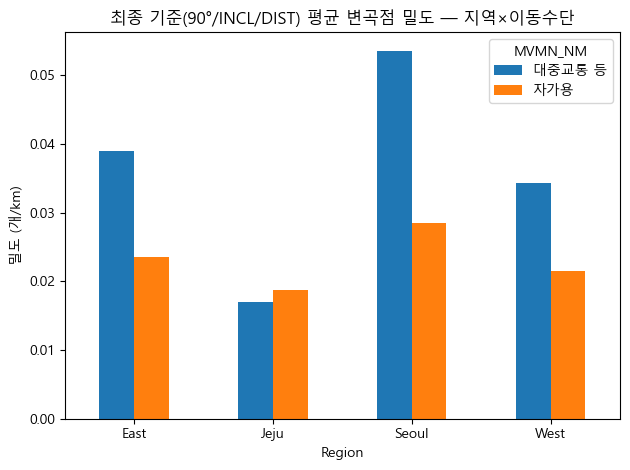

<Figure size 600x400 with 0 Axes>

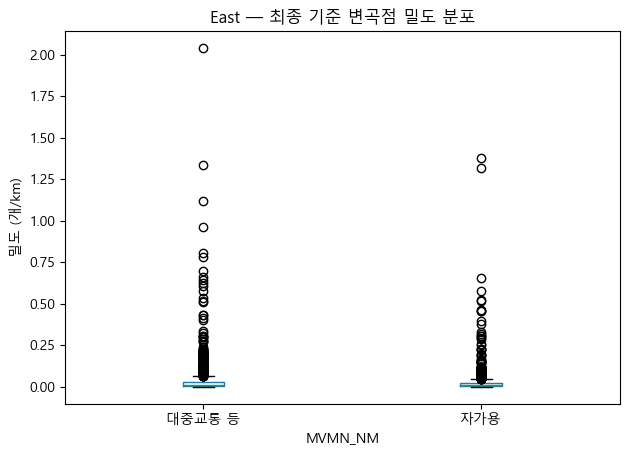

<Figure size 600x400 with 0 Axes>

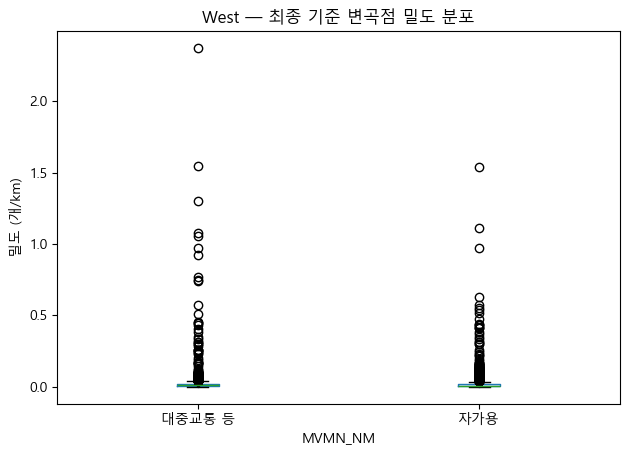

<Figure size 600x400 with 0 Axes>

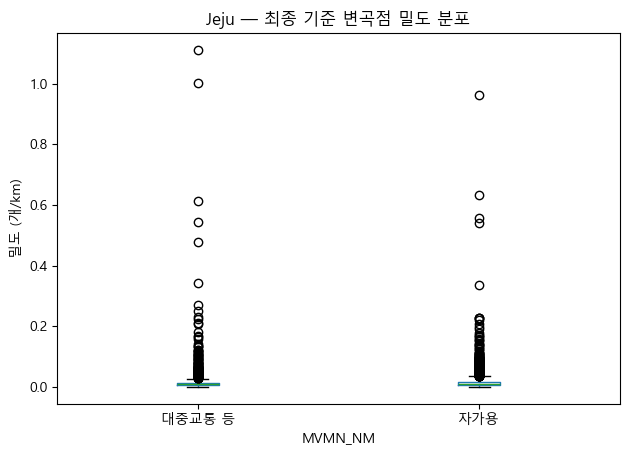

<Figure size 600x400 with 0 Axes>

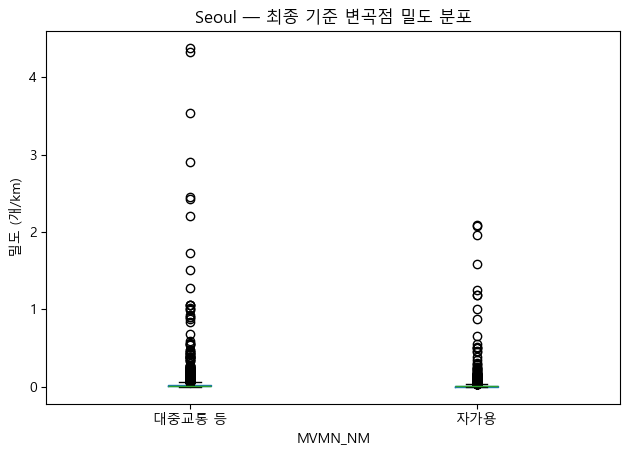

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

CANON_COL = "DENSITY_ABS_90_INCL_DIST"
m = pd.read_csv("metrics_all_regions.csv")

# 1) 지역×이동수단 평균 막대
plt.figure(figsize=(8,5))
(
    m.groupby(["Region","MVMN_NM"])[CANON_COL]
     .mean()
     .unstack("MVMN_NM")
).plot(kind="bar")
plt.title("최종 기준(90°/INCL/DIST) 평균 변곡점 밀도 — 지역×이동수단")
plt.ylabel("밀도 (개/km)")
plt.xlabel("Region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) 지역별 박스플롯(자가용 vs 대중교통)
regions_order = m["Region"].unique().tolist()
for r in regions_order:
    sub = m[m["Region"]==r]
    plt.figure(figsize=(6,4))
    sub.boxplot(column=CANON_COL, by="MVMN_NM", grid=False)
    plt.title(f"{r} — 최종 기준 변곡점 밀도 분포")
    plt.suptitle("")
    plt.xlabel("MVMN_NM")
    plt.ylabel("밀도 (개/km)")
    plt.tight_layout()
    plt.show()

전국/지역별 검정표와 원자료 CSV

In [10]:
# 최종 기준: ABS_90 + INCL + DIST
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

METRICS = "metrics_all_regions.csv"   # 동/서/제주/수도 통합 메트릭
STATS   = "stats_all_regions.csv"     # 동/서/제주/수도 통합 가설검정(p값)

# -----------------------------
# A. 원자료(개별 TRAVEL_ID 값) 준비
# -----------------------------
m = pd.read_csv(METRICS)

COL = "DENSITY_ABS_90_INCL_DIST"   # 최종 지표 1개
keep_cols = [c for c in ["Region","TRAVEL_ID","MVMN_NM",COL] if c in m.columns]
df = m[keep_cols].rename(columns={COL:"VALUE"}).dropna(subset=["VALUE","MVMN_NM"])

# 저장(추가 분석용)
df.to_csv("최종기준_전국_개별값.csv", index=False, encoding="utf-8-sig")

# -----------------------------
# B. 지역별 Mann–Whitney + Cliff’s delta
# -----------------------------
def cliffs_delta(x, y):
    # 작은 표본에서도 빠르게: 브루트포스보단 정렬 기반이 일반적이지만 여기선 간단 버전
    x = np.asarray(x); y = np.asarray(y)
    n_x, n_y = len(x), len(y)
    # 벡터화 비교
    diffs = x.reshape(-1,1) - y.reshape(1,-1)
    return (np.sum(diffs > 0) - np.sum(diffs < 0)) / (n_x * n_y)

rows = []
for region, g in df.groupby("Region"):
    a = g.loc[g["MVMN_NM"]=="자가용","VALUE"]
    b = g.loc[g["MVMN_NM"]=="대중교통 등","VALUE"]
    if len(a)==0 or len(b)==0:
        continue
    u, p = mannwhitneyu(a, b, alternative="two-sided")
    cd = cliffs_delta(b, a)  # (대중교통 - 자가용) 방향
    rows.append({
        "Region":"By-Region",
        "Subregion": region,
        "n_auto": len(a), "n_public": len(b),
        "auto_mean": a.mean(), "public_mean": b.mean(),
        "U_stat": u, "p_value": p, "cliffs_delta": cd
    })

# -----------------------------
# C. 전국 단위 Mann–Whitney + Cliff’s delta
# -----------------------------
aN = df.loc[df["MVMN_NM"]=="자가용","VALUE"]
bN = df.loc[df["MVMN_NM"]=="대중교통 등","VALUE"]
uN, pN = mannwhitneyu(aN, bN, alternative="two-sided")
cdN = cliffs_delta(bN, aN)

rows.append({
    "Region":"National",
    "Subregion":"National",
    "n_auto": len(aN), "n_public": len(bN),
    "auto_mean": aN.mean(), "public_mean": bN.mean(),
    "U_stat": uN, "p_value": pN, "cliffs_delta": cdN
})

out = pd.DataFrame(rows)
out.to_csv("최종기준_p값_지역별_및_전국.csv", index=False, encoding="utf-8-sig")

print("✅ 저장 완료")
print(" - 최종기준_전국_개별값.csv")
print(" - 최종기준_p값_지역별_및_전국.csv")
out

✅ 저장 완료
 - 최종기준_전국_개별값.csv
 - 최종기준_p값_지역별_및_전국.csv


,Region,Subregion,n_auto,n_public,auto_mean,public_mean,U_stat,p_value,cliffs_delta
0,By-Region,East,2226,1339,0.023560,0.039036,1327799.0,4.751964e-08,0.109043
1,By-Region,Jeju,2064,1750,0.018692,0.017037,1763099.0,2.055150e-01,0.023755
2,By-Region,Seoul,1635,1701,0.028490,0.053592,1155886.0,3.206803e-17,0.168767
3,By-Region,West,2430,1098,0.021446,0.034306,1154640.0,1.498586e-10,0.134498
4,National,National,8355,5888,0.022707,0.035821,22504256.0,4.684315e-18,0.085086


전국 기준(National)은 p값이 4.68e-18로 매우 작아서, 제주를 포함해도 통계적으로 유의미

전국(National) 결과
p-value: 4.68 × 10⁻¹⁸ → 귀무가설(이동수단별 차이 없음) 기각
평균값:
자가용: 0.022707
대중교통: 0.035821
효과크기(Cliff’s delta): 0.085 → 소효과지만 방향은 “대중교통 > 자가용”
전국 단위로는 유의한 차이 존재 (대중교통이 변곡점 밀도가 높음)

지역별
동부(East), 서부(West), 수도권(Seoul): 모두 p<0.001 수준으로 유의
제주(Jeju): p=0.205 → 유의하지 않음 (평균도 자가용이 약간 더 높음)

전국 평균/분포 빠른 확인 플롯

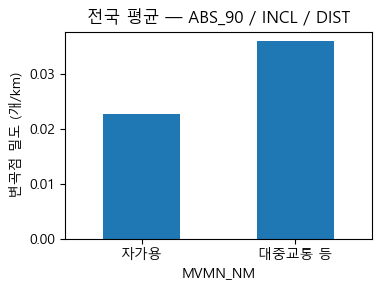

                    mean    median       std  count
Region MVMN_NM                                     
East   대중교통 등   0.039036  0.013659  0.106314   1339
       자가용      0.023560  0.011508  0.058078   2226
Jeju   대중교통 등   0.017037  0.009434  0.047523   1750
       자가용      0.018692  0.009092  0.039146   2064
Seoul  대중교통 등   0.053592  0.008510  0.239600   1701
       자가용      0.028490  0.005815  0.122033   1635
West   대중교통 등   0.034306  0.010685  0.127584   1098
       자가용      0.021446  0.008613  0.061992   2430


In [11]:
import matplotlib.pyplot as plt

# 전국 평균 막대
grp = df.groupby("MVMN_NM")["VALUE"].mean().reindex(["자가용","대중교통 등"])
plt.figure(figsize=(4,3))
grp.plot(kind="bar")
plt.ylabel("변곡점 밀도 (개/km)")
plt.title("전국 평균 — ABS_90 / INCL / DIST")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 지역×이동수단 평균(표 한 번 더 보기)
print(df.groupby(["Region","MVMN_NM"])["VALUE"].agg(["mean","median","std","count"]))